In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [32]:
# train_dataset = tv.datasets.FashionMNIST(root='../Datasets/',train=True, download=True)
# test_dataset = tv.datasets.FashionMNIST(root='../Datasets/',train=False, download=True)
# transformations
transform = T.Compose([T.ToTensor(), T.Normalize([0.5], [0.5])])

# import the data and simultaneously apply the transform
trainset = tv.datasets.FashionMNIST(
    root="../Datasets/", train=True, download=True, transform=transform
)
devtest = tv.datasets.FashionMNIST(
    root="../Datasets/", train=False, download=True, transform=transform
)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)  # a random permutation of indices
devset = Subset(devtest, randidx[:6000])  # Subset for devset
testset = Subset(devtest, randidx[6000:])  # Subset for test

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(
    trainset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
dev_loader = DataLoader(
    devset, batch_size=batchsize, generator=torch.Generator(device=device)
)  # note: devtest in batches!
test_loader = DataLoader(
    testset, batch_size=len(testset), generator=torch.Generator(device=device)
)

100%|██████████| 26.4M/26.4M [00:04<00:00, 6.43MB/s]


Extracting ../Datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../Datasets/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 188kB/s]


Extracting ../Datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../Datasets/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.46MB/s]


Extracting ../Datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../Datasets/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 29.1MB/s]

Extracting ../Datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../Datasets/FashionMNIST/raw



Data shapes (train/test):
torch.Size([32, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))
Classes:  10


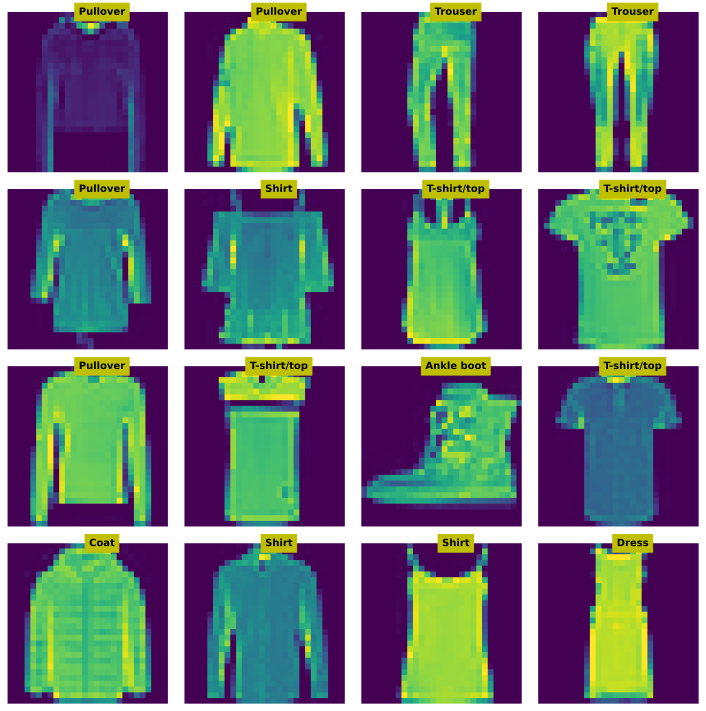

In [36]:
X, y = next(iter(train_loader))

# try again
print("Data shapes (train/test):")
print(X.data.shape)

# and the range of pixel intensity values
print("\nData value range:")
print((torch.min(X.data), torch.max(X.data)))
print("Classes: ", len(trainset.classes))
# inspect a few random images

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [38]:
# Create a function to create a model
# Basic knowledge
# Image size = 32X32
# Output class predictions = 10
def createFMNISTNet(print_toggle=False):
    class fmnistNet(nn.Module):

        def __init__(self, print_toggle):
            super().__init__()
            self.print = print_toggle

            # Convolution layers
            self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)
            # Output => (32 + 2*1 - 3 / 1 + 1 / 2) => 16
            self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(128)
            # Output => (16 + 2*1 - 3 / 1 + 1 / 2) => 8
            self.conv3 = nn.Conv2d(128, 256, 3)
            self.bnorm3 = nn.BatchNorm2d(256)
            # Output => (8 + 2*1 - 3 / 1 + 1 / 2) => 4

            # Fully Connected Layers
            self.fc1 = nn.Linear(2 * 2 * 256, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 10)

        def forward(self, x):
            if self.print:
                print(f"Input: {list(x.shape)}")

            # Conv 1
            x = self.conv1(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm1(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"Conv1 Output: {list(x.shape)}")
            # Conv 2
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm2(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"Conv2 Output: {list(x.shape)}")

            # Conv 3
            x = self.conv3(x)
            x = F.max_pool2d(x, 2)
            x = self.bnorm3(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"Conv3 Output: {list(x.shape)}")

            # Reshape for the Linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            # Linear Layers

            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = self.fc3(x)
            if self.print:
                print(f"Final output: {list(x.shape)}")
            return x

    # Model instance
    net = fmnistNet(print_toggle)

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

    return net, lossFun, optimizer

In [39]:
# Test with some data
net, lossFun, optimizer = createFMNISTNet(True)

# Some data
X, y = next(iter(train_loader))
print(X.shape, y.shape)
yHat = net(X.to(device))
# Check the output size
print(f"Output size: {yHat.shape}\n")

# Loss Function
loss = lossFun(yHat, torch.squeeze(y.to(device)))
print(f"Loss: {loss}")

torch.Size([32, 1, 28, 28]) torch.Size([32])
Input: [32, 1, 28, 28]
Conv1 Output: [32, 64, 14, 14]
Conv2 Output: [32, 128, 7, 7]
Conv3 Output: [32, 256, 2, 2]
Vectorized: [32, 1024]
Final output: [32, 10]
Output size: torch.Size([32, 10])

Loss: 2.3224542140960693


In [40]:
def functionToTrainTheModel(numepochs=5, print_toggle=False):
    # create a new model
    net, lossfun, optimizer = createFMNISTNet(print_toggle)

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        print(f"Started Epoch: {epochi+1} / {numepochs}")
        # loop over training data batches
        net.train()  # switch to train mode
        batchLoss = []
        batchAcc = []
        for X, y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = torch.squeeze(y.to(device))

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
            batchAcc.append(
                torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            )
        # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100 * np.mean(batchAcc)

        #### test performance (here done in batches!)
        net.eval()  # switch to test mode
        batchAcc = []
        batchLoss = []
        for X, y in dev_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat, torch.squeeze(y.to(device)))

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
            batchAcc.append(
                torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            )
        # end of batch loop...

        # and get average losses and accuracies across the batches
        devLoss[epochi] = np.mean(batchLoss)
        devAcc[epochi] = 100 * np.mean(batchAcc)

    # end epochs
    print(f"Completed Epoch: {epochi+1} / {numepochs}")
    # function output
    return trainLoss, devLoss, trainAcc, devAcc, net

In [ ]:
# Test the model
trainLosses, devLosses, trainErrors, devErrors, net = functionToTrainTheModel(
    numepochs=10, print_toggle=False
)

Started Epoch: 1 / 10


In [ ]:
## the real test set!

net.eval()  # switch to test mode
X, y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
    yHat = net(X)
    loss = lossFun(yHat, y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc = 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLosses.cpu(), "s-", label="Train")
ax[0].plot(devLosses.cpu(), "o-", label="Dev")
ax[0].plot(len(devLosses.cpu()) - 1, testLoss, "r*", markersize=15, label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (CEL)")
ax[0].set_title("Model loss")

ax[1].plot(trainErrors.cpu(), "s-", label="Train")
ax[1].plot(devErrors.cpu(), "o-", label="Dev")
ax[1].plot(len(devErrors.cpu()) - 1, testAcc, "r*", markersize=15, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model dev/test accuracy: {devErrors[-1]:.2f}/{testAcc:.2f}%")
ax[1].legend()

plt.show()